List of tasks from Justin:
- Revisit the S2 cell data and create a list of SRX accessions for RNA-Seq and ChIP-Seq. Send me this list and I will look at the current SRA and see if there are more datasets we should include.
- Make weights matrices for motifs using median p-value for all motifs that overlap gene + upstream region
- Make weights matrices for ChIP-Seq based on peak nearest to TSS (p-value).
- Make conservation score weight matrix. Use median PhastCons score of 2kb +/- gene start. 


In [2]:
import pandas as pd
import pybedtools

In [3]:
spreadsheet = pd.read_csv('../output/chip/20171103_s2cell_chip-seq.csv')

In [4]:
spreadsheet.srx.to_csv('../output/chip/list_of_s2_chip_srxs', sep='\t', index=False)

In [5]:
expmatrix = pd.read_table('../output/rna_seq/2018-03-14_s2_rnaseq_rpkm_gene_counts.tsv', index_col=0)

In [6]:
pd.DataFrame(expmatrix.columns.tolist()).to_csv('../output/chip/list_of_s2_exp_srxs', sep='\t', index=False)

### weight matrix for motifs with median p val


In [7]:
tf_merge = pd.read_table('../output/motif/tf_merge.bed', header=None, names=['chrom', 'start','end','pval','motif_symbol','motif_FBgn'])

In [8]:
#filter for RNAi TFs


TF_list = pd.read_table('../output/list_of_tfs.txt', header=None)
TF_list.columns=['TF']


# make dictionary of alt fbgns

fbgn = {}
with open('/data/LCDB/lcdb-references/dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation') as f:
    next(f)
    for line in f:
        split = line.split('\t')
        first = split[1]
        seconds = split[2].split(',')
        fbgn[first] = first
        for x in seconds:
            if x:
                fbgn[x] = first
                
TF_list['update'] = TF_list.TF.map(lambda x: fbgn[x])
TF_list.drop('TF', axis=1, inplace=True)
merge_on_our_TFs = tf_merge.merge(TF_list, left_on='motif_FBgn', right_on='update', how='inner')
len(merge_on_our_TFs.motif_FBgn.unique())


116

In [9]:
gene_info = pybedtools.BedTool('../output/chip/dmel6.12.genes.bed')

In [10]:
#target gene intersect


targene_intersect = gene_info.intersect(pybedtools.BedTool.from_dataframe(merge_on_our_TFs), 
                                        wb=True).saveas().to_dataframe()[[3,6,7,8,9,10,11]]
targene_intersect.columns = ['target_gene','chrom','start','end','pval','motif_symbol','motif_fbgn']

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.6/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [11]:
#make sure all FBgns are updated
targene_intersect['update_fbgn'] = targene_intersect.motif_fbgn.map(lambda x: fbgn[x])
targene_intersect.head()

,target_gene,chrom,start,end,pval,motif_symbol,motif_fbgn,update_fbgn
0,FBgn0002121,chr2L,13097,13107,0.000024,br-Z3,FBgn0283451,FBgn0283451
1,FBgn0002121,chr2L,11683,11690,0.000072,br-Z4,FBgn0283451,FBgn0283451
2,FBgn0002121,chr2L,11526,11533,0.000089,br-Z2,FBgn0283451,FBgn0283451
3,FBgn0002121,chr2L,11526,11533,0.000097,br,FBgn0283451,FBgn0283451
4,FBgn0002121,chr2L,16133,16140,0.000080,br,FBgn0283451,FBgn0283451


In [101]:
agg = targene_intersect.groupby(['target_gene', 'update_fbgn']).agg({'pval':['median']})
agg.columns = ['median_pval']
collapsed = agg.reset_index()

In [102]:
collapsed.head()

,target_gene,update_fbgn,median_pval
0,FBgn0000008,FBgn0000097,0.000055
1,FBgn0000008,FBgn0000286,0.000036
2,FBgn0000008,FBgn0000370,0.000053
3,FBgn0000008,FBgn0000546,0.000039
4,FBgn0000008,FBgn0000567,0.000041


In [103]:
collapsed.set_index(['target_gene', 'update_fbgn'], inplace=True)
matrix = collapsed.unstack()

In [98]:
matrix.fillna(value=0)

## ChIP weight matrix based on peak nearest TSS

In [16]:
#hmmmm score is -log10 qvalue... get pvalue??????? need to go back to the "checking peak calls" notebook
#UPDATE: changed the score to -log10 p value

tf = pd.read_table('../output/chip/tf_chip_targeneintersect')
tf.head()

,target_gene,chrom,start,end,srx,log10qval,caller,TF,TF_fbgn,update_fbgn
0,FBgn0031208,chr2L,8116,8192,SRX885700,10.89322,macs2,Scm,FBgn0003334,FBgn0003334
1,FBgn0031208,chr2L,8116,8192,SRX885698,61.84684,macs2,Scm,FBgn0003334,FBgn0003334
2,FBgn0031208,chr2L,8116,8192,SRX097617,139.82581,macs2,lilli,FBgn0041111,FBgn0041111
3,FBgn0031208,chr2L,8116,8192,SRX097617,-1.00000,spp,lilli,FBgn0041111,FBgn0041111
4,FBgn0031208,chr2L,8116,8192,SRX097617,-1.00000,spp,lilli,FBgn0041111,FBgn0041111


In [17]:
#convert values from -log10
tf['pval'] = [10**-x for x in tf.log10qval]

In [18]:
tf_new = tf[['chrom','start','end','target_gene','pval','TF','update_fbgn']]

In [19]:
#intersect with TSS information

In [20]:
tf_new.sort_values(by=['chrom','start','end'], inplace=True)

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
#import tss file names=['chrom','start','end','name','score','strand'])
tss = pybedtools.BedTool('../output/motif/tsses.bed')

#get tss gene
tss_wgene = gene_info.intersect(tss, wb=True).saveas().to_dataframe()

In [22]:
tss_wgene_2 = tss_wgene[['thickStart','thickEnd','itemRgb','blockCount',
                         'name']]

In [23]:
tss_wgene_2.sort_values(by=['thickStart','thickEnd','itemRgb'], inplace=True)

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
tss_intersect = pybedtools.BedTool.from_dataframe(tss_wgene_2).closest(pybedtools.BedTool.from_dataframe(tf_new), 
                                                                       d=True).saveas().to_dataframe()

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.6/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [25]:
tss_intersect.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr2L,7528,7529,FBtr0300689,FBgn0031208,chr2L,8116,8192,FBgn0031208,1.278733e-11,Scm,FBgn0003334,588
1,chr2L,7528,7529,FBtr0300689,FBgn0031208,chr2L,8116,8192,FBgn0031208,1.422853e-62,Scm,FBgn0003334,588
2,chr2L,7528,7529,FBtr0300689,FBgn0031208,chr2L,8116,8192,FBgn0031208,1.493448e-140,lilli,FBgn0041111,588
3,chr2L,7528,7529,FBtr0300689,FBgn0031208,chr2L,8116,8192,FBgn0031208,1.000000e+01,lilli,FBgn0041111,588
4,chr2L,7528,7529,FBtr0300689,FBgn0031208,chr2L,8116,8192,FBgn0031208,1.000000e+01,lilli,FBgn0041111,588


In [26]:
tss_agg = tss_intersect.groupby([8, 11]).agg({12: 'min'})
tss_agg.columns = ['min_dist_tss']
tss_agg.head()

min_dist_tss
8           11                       
FBgn0000008 FBgn0001206           241
            FBgn0003334           241
            FBgn0010328             1
            FBgn0033998             1
            FBgn0038016             1

In [27]:
take_min_dist = tss_intersect.loc[tss_intersect.groupby([8, 11])[12].idxmin()]

In [28]:
chip_pvals = take_min_dist[[8, 11, 9]]
chip_pvals.columns = ['target_gene', 'tf', 'pval']

In [29]:
chip_pvals.set_index(['target_gene', 'tf'], inplace=True)
chipmatrix = chip_pvals.unstack()

In [30]:
chipmatrix.fillna(value=0)

pval                                             \
tf             FBgn0000283   FBgn0001206    FBgn0002775   FBgn0003042   
target_gene                                                             
FBgn0000008   0.000000e+00  4.254123e-05   0.000000e+00  0.000000e+00   
FBgn0000014   0.000000e+00  0.000000e+00   0.000000e+00  7.551618e-98   
FBgn0000015   2.837788e-47  0.000000e+00   0.000000e+00  1.000000e+01   
FBgn0000017   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000024   1.000000e+01  0.000000e+00   0.000000e+00  2.834654e-08   
FBgn0000028   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000032   0.000000e+00  0.000000e+00   1.463828e-15  0.000000e+00   
FBgn0000036   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000037   1.000000e+01  0.000000e+00   0.000000e+00  5.954976e-08   
FBgn0000038   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000039   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000042   4.229607e-53  0.000000e+00   1.000000e+01  0.000000e+00   
FBgn0000043  2.393812e-190  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000047   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000052   1.000000e+01  0.000000e+00   2.990474e-08  0.000000e+00   
FBgn0000053   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000054   1.915226e-29  3.317035e-10   0.000000e+00  0.000000e+00   
FBgn0000055   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000056   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000057   0.000000e+00  0.000000e+00   1.000000e+01  0.000000e+00   
FBgn0000061   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000063   3.960956e-52  0.000000e+00   2.485192e-34  0.000000e+00   
FBgn0000064   8.183329e-06  1.517609e-08   0.000000e+00  0.000000e+00   
FBgn0000071   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000075   0.000000e+00  0.000000e+00   0.000000e+00  5.063957e-05   
FBgn0000083   1.000000e+01  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000084   1.000000e+01  0.000000e+00   1.000000e+01  0.000000e+00   
FBgn0000092   0.000000e+00  0.000000e+00   1.661728e-59  0.000000e+00   
FBgn0000094   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0000097   5.315817e-28  0.000000e+00   0.000000e+00  0.000000e+00   
...                    ...           ...            ...           ...   
FBgn0283479   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0283499   7.464144e-12  0.000000e+00   1.000000e+01  0.000000e+00   
FBgn0283501   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0283503   0.000000e+00  0.000000e+00   2.099617e-26  0.000000e+00   
FBgn0283509   1.000000e+01  0.000000e+00   2.251905e-11  0.000000e+00   
FBgn0283510   9.116959e-19  0.000000e+00   1.000000e+01  0.000000e+00   
FBgn0283521   5.354883e-23  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0283531   3.319021e-07  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0283535   1.000000e+01  0.000000e+00   5.098472e-19  0.000000e+00   
FBgn0283536   1.000000e+01  0.000000e+00   1.000000e+01  0.000000e+00   
FBgn0283545   0.000000e+00  0.000000e+00  5.048938e-211  0.000000e+00   
FBgn0283546   1.000000e+01  0.000000e+00   3.086740e-15  0.000000e+00   
FBgn0283548   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0283559   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0283626   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0283627   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0283638   1.988337e-12  8.888941e-64   0.000000e+00  0.000000e+00   
FBgn0283649   1.000000e+01  0.000000e+00   9.201741e-14  0.000000e+00   
FBgn0283651   1.000000e+01  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0283652   0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn0283657   1.000000e+01  0.000000e+00   0.000000e+00  0.000000e+00   
FBgn028

## Histone Chip weight matrix based on nearest tss

In [38]:
hist = pd.read_table('../output/chip/hist_chip_targeneintersect')
hist.head()

,target_gene,chrom,start,end,srx,log10qval,caller,antibody
0,FBgn0031208,chr2L,6528,11179,SRX193335,43.21521,macs2,H3K4me1
1,FBgn0031208,chr2L,6528,10460,SRX193336,39.33482,macs2,H3K4me1
2,FBgn0031208,chr2L,6528,10035,SRX193321,20.15121,macs2,H3K4me1
3,FBgn0031208,chr2L,7440,9409,SRX193334,5.01516,macs2,H3K27me3
4,FBgn0031208,chr2L,7525,9406,SRX193320,4.28135,macs2,H3K27me3


In [39]:
#convert values from -log10
hist['pval'] = [10**-x for x in hist.log10qval]

In [43]:
hist_new = hist[['chrom','start','end','target_gene','pval','antibody']]

In [44]:
hist_new.sort_values(by=['chrom','start','end'], inplace=True)

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
tss_hist_intersect = pybedtools.BedTool.from_dataframe(tss_wgene_2).closest(pybedtools.BedTool.from_dataframe(hist_new), 
                                                                       d=True).saveas().to_dataframe()

In [46]:
tss_hist_intersect.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,chr2L,7528,7529,FBtr0300689,FBgn0031208,chr2L,6528,9419,FBgn0031208,3.430125e-17,H3K4me1,0
1,chr2L,7528,7529,FBtr0300689,FBgn0031208,chr2L,6528,10035,FBgn0031208,7.059761e-21,H3K4me1,0
2,chr2L,7528,7529,FBtr0300689,FBgn0031208,chr2L,6528,10035,FBgn0002121,7.059761e-21,H3K4me1,0
3,chr2L,7528,7529,FBtr0300689,FBgn0031208,chr2L,6528,10279,FBgn0031208,8.892216e-48,H3K4me1,0
4,chr2L,7528,7529,FBtr0300689,FBgn0031208,chr2L,6528,10279,FBgn0002121,8.892216e-48,H3K4me1,0


In [47]:
tss_histagg = tss_hist_intersect.groupby(['itemRgb','blockSizes']).agg({'blockStarts': 'min'})
tss_histagg.columns = ['min_dist_tss']
tss_histagg.head()

min_dist_tss
itemRgb     blockSizes              
FBgn0000003 CTCF                   0
FBgn0000008 CTCF                   0
            H3K27me3               0
            H3K4me1                0
            His2Av                 0

In [48]:
take_min_dist_hist = tss_hist_intersect.loc[tss_hist_intersect.groupby(['itemRgb',
                                                'blockSizes'])['blockStarts'].idxmin()]

In [51]:
histpvals = take_min_dist_hist[['itemRgb','blockSizes','blockCount']]
histpvals.columns = ['target_gene', 'antibody', 'pval']

In [52]:
histpvals.set_index(['target_gene', 'antibody'], inplace=True)
histmatrix = histpvals.unstack()

In [53]:
histmatrix.fillna(value=0)

pval                                            \
antibody             CTCF       H3K27ac      H3K27me3      H3K36me3   
target_gene                                                           
FBgn0000003  3.192640e-12  0.000000e+00  0.000000e+00  0.000000e+00   
FBgn0000008  1.463895e-12  0.000000e+00  3.255892e-04  0.000000e+00   
FBgn0000014  2.981467e-16  0.000000e+00  3.091648e-08  0.000000e+00   
FBgn0000015  2.049651e-57  0.000000e+00  1.424394e-08  0.000000e+00   
FBgn0000017  9.659174e-34  0.000000e+00  0.000000e+00  0.000000e+00   
FBgn0000018  0.000000e+00  0.000000e+00  0.000000e+00  2.372848e-19   
FBgn0000024  3.991811e-15  0.000000e+00  3.790792e-03  0.000000e+00   
FBgn0000028  0.000000e+00  0.000000e+00  1.117918e-03  0.000000e+00   
FBgn0000032  0.000000e+00  1.038030e-54  0.000000e+00  7.037526e-21   
FBgn0000036  0.000000e+00  0.000000e+00  1.114962e-03  0.000000e+00   
FBgn0000037  9.061081e-12  0.000000e+00  3.215585e-04  0.000000e+00   
FBgn0000038  0.000000e+00  0.000000e+00  8.006081e-04  0.000000e+00   
FBgn0000039  0.000000e+00  0.000000e+00  2.492126e-05  0.000000e+00   
FBgn0000042  1.400458e-05  3.109138e-54  0.000000e+00  0.000000e+00   
FBgn0000043  3.969995e-57  9.940312e-66  0.000000e+00  0.000000e+00   
FBgn0000044  0.000000e+00  0.000000e+00  6.843370e-06  0.000000e+00   
FBgn0000045  0.000000e+00  0.000000e+00  1.355720e-06  0.000000e+00   
FBgn0000046  2.886755e-03  0.000000e+00  0.000000e+00  0.000000e+00   
FBgn0000047  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
FBgn0000052  1.024236e-26  0.000000e+00  0.000000e+00  2.817150e-38   
FBgn0000053  9.118429e-05  6.050064e-26  0.000000e+00  6.097755e-09   
FBgn0000054  9.376268e-56  6.110264e-48  0.000000e+00  9.190941e-50   
FBgn0000055  0.000000e+00  0.000000e+00  2.797757e-06  0.000000e+00   
FBgn0000056  0.000000e+00  0.000000e+00  2.797757e-06  0.000000e+00   
FBgn0000057  3.338105e-06  1.857762e-34  0.000000e+00  1.060620e-16   
FBgn0000061  0.000000e+00  0.000000e+00  4.853555e-05  0.000000e+00   
FBgn0000063  1.615400e-53  1.976332e-23  0.000000e+00  6.311462e-19   
FBgn0000064  5.504147e-23  4.951195e-49  0.000000e+00  3.478404e-15   
FBgn0000071  5.573526e-10  8.846470e-29  0.000000e+00  0.000000e+00   
FBgn0000075  0.000000e+00  0.000000e+00  7.250200e-04  0.000000e+00   
...                   ...           ...           ...           ...   
FBgn0283545  0.000000e+00  4.906932e-22  0.000000e+00  1.122897e-28   
FBgn0283546  0.000000e+00  4.278091e-22  0.000000e+00  6.977663e-13   
FBgn0283548  0.000000e+00  1.211156e-23  0.000000e+00  9.333618e-21   
FBgn0283549  0.000000e+00  1.093352e-20  0.000000e+00  0.000000e+00   
FBgn0283550  0.000000e+00  0.000000e+00  0.000000e+00  7.086960e-23   
FBgn0283551  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
FBgn0283553  0.000000e+00  0.000000e+00  0.000000e+00  5.421632e-17   
FBgn0283555  0.000000e+00  1.762747e-18  0.000000e+00  0.000000e+00   
FBgn0283559  0.000000e+00  1.972559e-23  0.000000e+00  0.000000e+00   
FBgn0283560  0.000000e+00  4.814487e-29  0.000000e+00  1.015126e-23   
FBgn0283561  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
FBgn0283562  0.000000e+00  0.000000e+00  0.000000e+00  4.568672e-27   
FBgn0283625  0.000000e+00  0.000000e+00  4.159393e-03  0.000000e+00   
FBgn0283626  0.000000e+00  0.000000e+00  2.156950e-03  0.000000e+00   
FBgn0283627  0.000000e+00  0.000000e+00  5.215429e-04  0.000000e+00   
FBgn0283638  3.525575e-05  9.041074e-37  0.000000e+00  0.000000e+00   
FBgn0283649  5.304323e-08  3.437558e-70  0.000000e+00  3.756298e-20   
FBgn0283651  0.000000e+00  0.000000e+00  4.318968e-05  0.000000e+00   
FBgn0283652  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
FBgn0283657  2.717002e-88  1.135952e-40  0.000000e+00  0.000000e+00   
FBgn0283658  1.450040e-41  4.732602e-20  0.000000e+00  3.619512e-17   
FBgn0283659  0.000000e+00  0.000000e+00  0.000000e+00  7.078317e-43   
FBgn0283666  0.000000e+00  1.340294e-80  0.00

### conservation score weight matrix using median PhastCons score

In [54]:
phastcons = pd.read_table('../output/motif/wmotif_gene_phastcons_in_region', header=None)[[0,1,2,3,4,5,7,8,9,10]]
phastcons.columns = ['chrom','start','end','pval','motifsymbol','motiffbgn','p_start','p_end','gene','phastcons']

In [55]:
phastcons.head()

,chrom,start,end,pval,motifsymbol,motiffbgn,p_start,p_end,gene,phastcons
0,chr2L,17019,17026,0.000036,br-Z1,.,17019,17020,FBgn0002121,0.007
1,chr2L,17019,17026,0.000036,br-Z1,.,17020,17021,FBgn0002121,0.006
2,chr2L,17019,17026,0.000036,br-Z1,.,17021,17022,FBgn0002121,0.005
3,chr2L,17019,17026,0.000036,br-Z1,.,17022,17023,FBgn0002121,0.002
4,chr2L,17019,17026,0.000036,br-Z1,.,17023,17024,FBgn0002121,0.000


In [ ]:
#fix blank motif fbgns

In [56]:
phastcons[phastcons.motiffbgn == '.'].motifsymbol.unique()

array(['br-Z1', 'br-Z3', 'br-Z4', 'BEAF-32B', 'br-Z2', 'Cf2-II', 'dsx-F',
       'dsx-M', 'Espl', 'His2B', 'HLHm5', 'p120', 'SuH', 'suHw'], dtype=object)

In [65]:
df_copy = phastcons.copy()

In [66]:
df_copy.loc[df_copy.motifsymbol == 'br-Z1', 'motiffbgn'] = 'FBgn0283451'
df_copy.loc[df_copy.motifsymbol == 'br-Z2', 'motiffbgn'] = 'FBgn0283451'
df_copy.loc[df_copy.motifsymbol == 'br-Z3', 'motiffbgn'] = 'FBgn0283451'
df_copy.loc[df_copy.motifsymbol == 'br-Z4', 'motiffbgn'] = 'FBgn0283451'
df_copy.loc[df_copy.motifsymbol == 'BEAF-32B', 'motiffbgn'] = 'FBgn0015602'
df_copy.loc[df_copy.motifsymbol == 'dsx-F', 'motiffbgn'] = 'FBgn0000504'
df_copy.loc[df_copy.motifsymbol == 'dsx-M', 'motiffbgn'] = 'FBgn0000504'
df_copy.loc[df_copy.motifsymbol == 'Espl', 'motiffbgn'] = 'FBgn0000591'
df_copy.loc[df_copy.motifsymbol == 'His2B', 'motiffbgn'] = 'FBgn0001198'
df_copy.loc[df_copy.motifsymbol == 'HLHm5', 'motiffbgn'] = 'FBgn0002631'
df_copy.loc[df_copy.motifsymbol == 'p120', 'motiffbgn'] = 'FBgn0260799'
df_copy.loc[df_copy.motifsymbol == 'suHw', 'motiffbgn'] = 'FBgn0003567'
df_copy.loc[df_copy.motifsymbol == 'SuH', 'motiffbgn'] = 'FBgn0004837'

In [67]:
#filter for RNAi tfs
merge_our_TFs = df_copy.merge(TF_list, left_on='motiffbgn', right_on='update', how='inner')
len(merge_our_TFs.motiffbgn.unique())

116

In [68]:
merge_our_TFs.head()

,chrom,start,end,pval,motifsymbol,motiffbgn,p_start,p_end,gene,phastcons,update
0,chr2L,17019,17026,0.000036,br-Z1,FBgn0283451,17019,17020,FBgn0002121,0.007,FBgn0283451
1,chr2L,17019,17026,0.000036,br-Z1,FBgn0283451,17020,17021,FBgn0002121,0.006,FBgn0283451
2,chr2L,17019,17026,0.000036,br-Z1,FBgn0283451,17021,17022,FBgn0002121,0.005,FBgn0283451
3,chr2L,17019,17026,0.000036,br-Z1,FBgn0283451,17022,17023,FBgn0002121,0.002,FBgn0283451
4,chr2L,17019,17026,0.000036,br-Z1,FBgn0283451,17023,17024,FBgn0002121,0.000,FBgn0283451


In [126]:
phast_agg = merge_our_TFs.groupby(['motiffbgn','gene']).agg({'phastcons':['median']})
phast_agg.columns = ['median_phastcons']
phast_collapse = phast_agg.reset_index()

In [127]:
phast_collapse.set_index(['gene', 'motiffbgn'], inplace=True)
phast_matrix = phast_collapse.unstack()

In [128]:
phast_matrix.fillna(value=0, inplace=True)

In [92]:
#look at distribution of phastcons scores/pvals

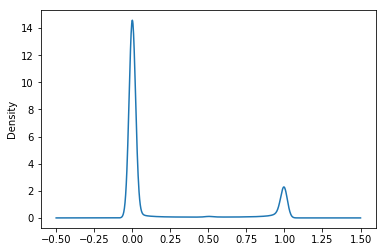

In [97]:
phast_matrix.melt().value.plot(kind='kde')

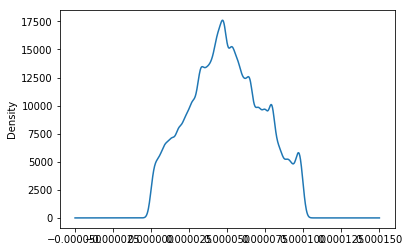

In [105]:
matrix.melt().value.plot(kind='kde')

In [ ]:
#can add together ? 

In [107]:
pval_matrix = matrix.fillna(value=0)

In [129]:
phast_matrix.columns = phast_matrix.columns.get_level_values(1)
phast_matrix.index.name = None
phast_matrix.columns.name = None
phast_matrix.head()

,FBgn0000097,FBgn0000286,FBgn0000370,FBgn0000546,FBgn0000567,FBgn0000568,FBgn0000611,FBgn0001078,FBgn0001168,FBgn0001185,...,FBgn0262656,FBgn0263108,FBgn0264075,FBgn0265276,FBgn0267033,FBgn0267821,FBgn0267978,FBgn0283451,FBgn0283521,FBgn0284249
FBgn0000008,1.0000,0.9765,1.0000,1.0000,1.0000,1.0000,1.000,0.999,1.000,0.9960,...,1.000,0.2780,1.0,0.0130,1.0000,0.9945,1.0,1.000,0.992,0.9970
FBgn0000014,0.9670,0.8310,0.0140,0.0000,0.9970,0.9985,1.000,1.000,0.992,0.9665,...,0.982,0.3415,1.0,0.5770,1.0000,0.9990,1.0,0.295,0.985,0.0810
FBgn0000015,1.0000,0.0165,1.0000,1.0000,0.6340,0.1250,0.816,0.969,0.909,0.9590,...,1.000,0.0510,1.0,0.2955,0.9940,0.9160,1.0,0.094,0.808,0.9855
FBgn0000017,0.9915,0.9320,0.4615,0.7175,0.2920,0.8250,0.026,0.994,0.062,0.9310,...,1.000,0.0105,1.0,0.0210,0.9630,0.9880,1.0,0.960,0.920,0.9770
FBgn0000024,0.9935,0.0340,1.0000,1.0000,0.9645,1.0000,0.399,1.000,1.000,0.9760,...,1.000,0.9870,1.0,0.0320,0.0155,0.9440,1.0,0.142,0.980,0.9920


In [119]:
pval_matrix.columns = pval_matrix.columns.get_level_values(1)
pval_matrix.index.name = None
pval_matrix.columns.name = None

In [130]:
pval_matrix.head()

,FBgn0000097,FBgn0000286,FBgn0000370,FBgn0000546,FBgn0000567,FBgn0000568,FBgn0000611,FBgn0001078,FBgn0001168,FBgn0001185,...,FBgn0262656,FBgn0263108,FBgn0264075,FBgn0265276,FBgn0267033,FBgn0267821,FBgn0267978,FBgn0283451,FBgn0283521,FBgn0284249
FBgn0000008,0.000055,0.000036,0.000053,0.000039,0.000041,0.000062,0.000061,0.000047,0.000029,0.000056,...,0.000063,0.000048,0.000044,0.000035,0.000070,0.000038,0.000045,0.000063,0.000049,0.000029
FBgn0000014,0.000065,0.000056,0.000018,0.000089,0.000052,0.000055,0.000048,0.000056,0.000026,0.000030,...,0.000067,0.000028,0.000028,0.000019,0.000074,0.000055,0.000048,0.000063,0.000049,0.000067
FBgn0000015,0.000031,0.000040,0.000063,0.000076,0.000049,0.000074,0.000037,0.000058,0.000073,0.000045,...,0.000060,0.000039,0.000052,0.000045,0.000065,0.000029,0.000048,0.000053,0.000045,0.000044
FBgn0000017,0.000074,0.000043,0.000053,0.000014,0.000082,0.000080,0.000055,0.000065,0.000035,0.000034,...,0.000048,0.000064,0.000035,0.000038,0.000049,0.000033,0.000093,0.000061,0.000045,0.000050
FBgn0000024,0.000035,0.000036,0.000057,0.000033,0.000059,0.000065,0.000048,0.000065,0.000047,0.000031,...,0.000082,0.000070,0.000052,0.000029,0.000069,0.000045,0.000048,0.000053,0.000052,0.000044


In [131]:
phast_matrix + pval_matrix

,FBgn0000097,FBgn0000286,FBgn0000370,FBgn0000546,FBgn0000567,FBgn0000568,FBgn0000611,FBgn0001078,FBgn0001168,FBgn0001185,...,FBgn0262656,FBgn0263108,FBgn0264075,FBgn0265276,FBgn0267033,FBgn0267821,FBgn0267978,FBgn0283451,FBgn0283521,FBgn0284249
FBgn0000008,1.000055,0.976536,1.000053,1.000039,1.000041,1.000062,1.000061,0.999047,1.000029,0.996056,...,1.000063,0.278048,1.000044,0.013035,1.000070,0.994538,1.000045,1.000063,0.992049,0.997029
FBgn0000014,0.967065,0.831056,0.014018,0.000089,0.997052,0.998555,1.000048,1.000056,0.992026,0.966530,...,0.982067,0.341528,1.000028,0.577019,1.000074,0.999055,1.000048,0.295063,0.985049,0.081067
FBgn0000015,1.000031,0.016540,1.000063,1.000075,0.634049,0.125074,0.816037,0.969058,0.909073,0.959045,...,1.000060,0.051039,1.000052,0.295545,0.994065,0.916029,1.000048,0.094053,0.808045,0.985544
FBgn0000017,0.991574,0.932043,0.461553,0.717514,0.292082,0.825080,0.026055,0.994065,0.062035,0.931034,...,1.000048,0.010564,1.000035,0.021038,0.963049,0.988033,1.000093,0.960060,0.920045,0.977050
FBgn0000024,0.993535,0.034036,1.000057,1.000033,0.964559,1.000065,0.399048,1.000065,1.000047,0.976031,...,1.000082,0.987070,1.000052,0.032029,0.015569,0.944045,1.000048,0.142052,0.980052,0.992044
FBgn0000028,0.983061,0.388037,0.002050,0.728023,0.406055,1.000028,0.528052,0.575036,1.000047,0.987068,...,1.000051,0.980025,1.000052,0.009542,0.162056,0.874035,1.000034,0.190057,0.440040,0.465054
FBgn0000032,0.000000,0.993078,0.000000,0.000000,0.000000,0.000000,0.000038,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.238024,0.000000,0.000000,0.367571,0.000000
FBgn0000036,1.000062,0.309038,1.000072,0.501040,0.997062,0.999046,1.000069,0.984046,0.994050,0.812052,...,1.000049,0.009088,1.000057,0.003037,0.989063,0.999043,1.000048,0.991053,0.978055,0.989038
FBgn0000037,1.000019,0.989042,0.000000,1.000065,0.000560,0.543087,1.000057,0.857512,1.000028,0.920063,...,1.000098,0.979025,0.994062,0.093522,0.990056,0.977044,0.997022,0.996061,0.971047,0.459068
FBgn0000038,0.000000,1.000053,1.000071,0.964075,1.000047,0.062535,1.000046,0.850009,0.000000,1.000039,...,0.000000,1.000050,1.000032,0.802523,0.165057,1.000023,0.996048,1.000036,0.999025,0.000000
